In [64]:
import pandas as pd
from datetime import datetime

# 设置目标时间和城市
target_dt = datetime.strptime("2018-09-29", "%Y-%m-%d")
city = "shanghai"

# 读取数据
df = pd.read_csv(f"{city}_trims_data.csv")

# 筛选出目标日白天的数据
day_of_year = target_dt.timetuple().tm_yday
filtered_df = df[(df['date'].isin([f'{str(day_of_year)}D'])) & (df['TRIMS_LST'] > 0) & (df['TRIMS_LST'] < 50)]

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

filtered_df = df[df['date'] == f'{str(day_of_year)}D'].copy()
filtered_df['lat'] = filtered_df['latitude'] / 10000
filtered_df['lon'] = filtered_df['longitude'] / 10000

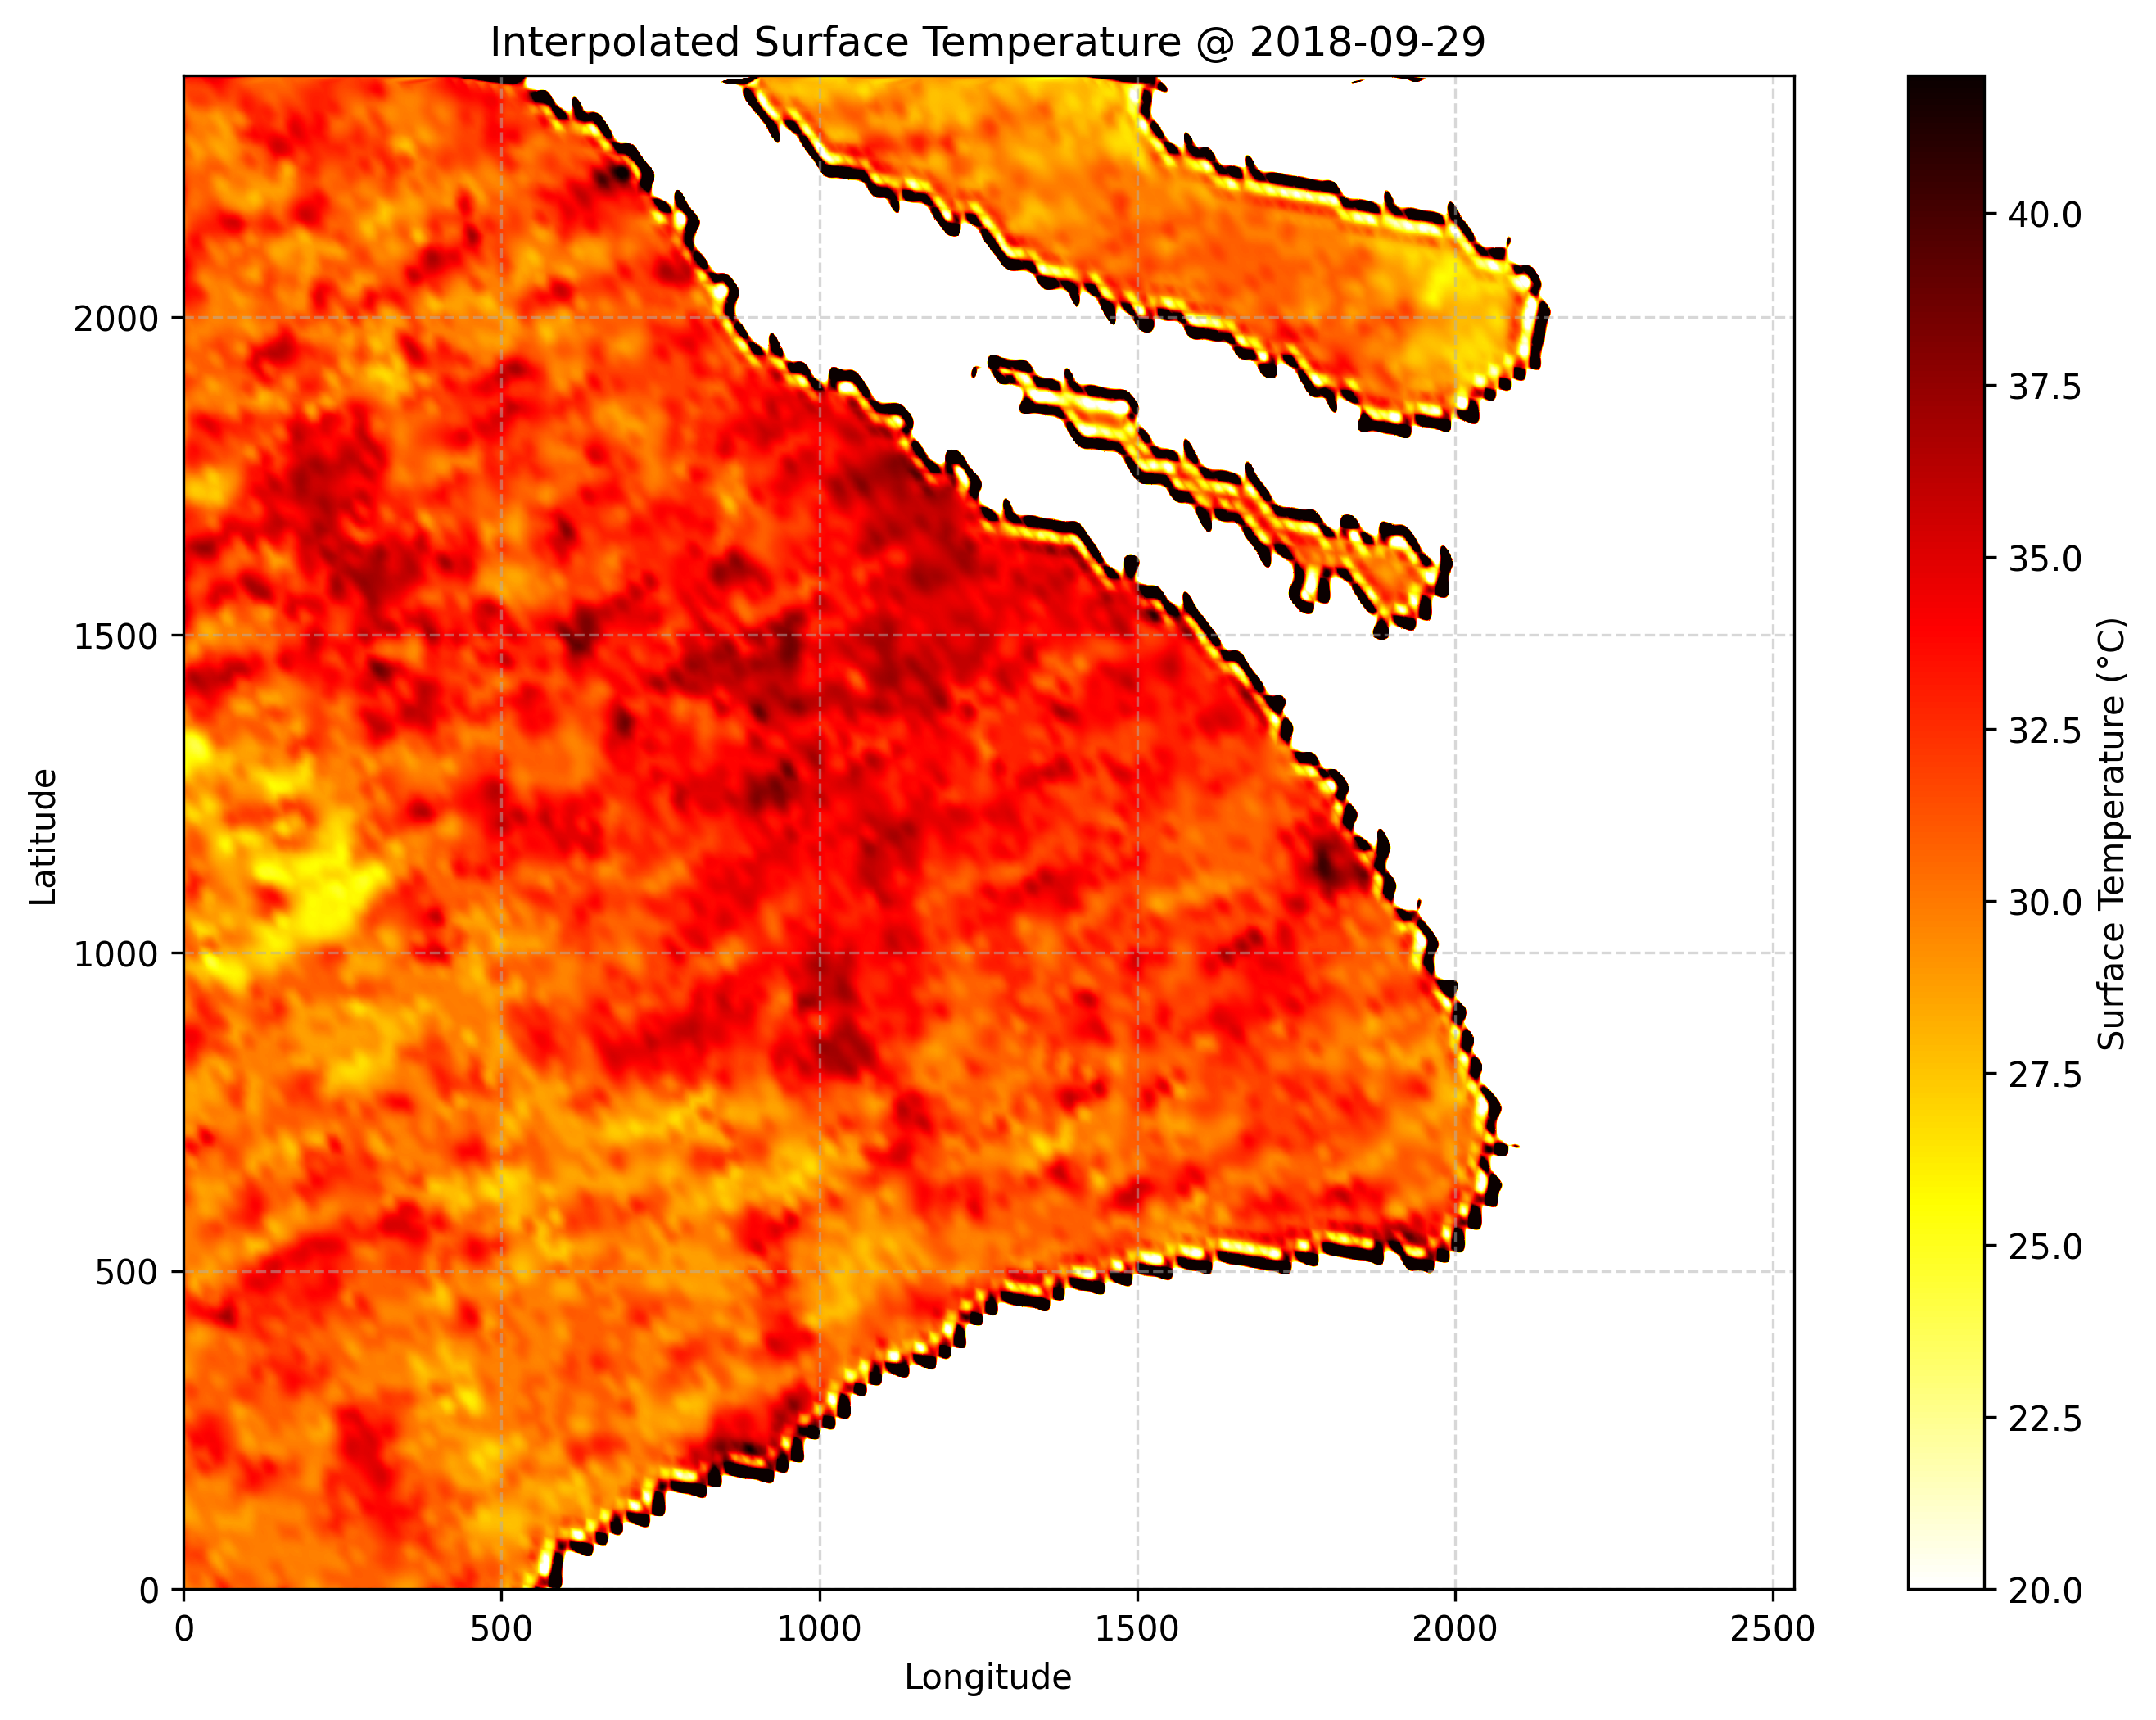

In [66]:
from scipy.interpolate import griddata

# 区域边界
if city == 'beijing':
    lon_l, lon_r, lat_b, lat_u = 115.43, 117.52, 39.44, 41.05
if city == 'shanghai':
    lon_l, lon_r, lat_b, lat_u = 120.836619, 122.165824, 30.631414, 31.7 #31.883925
if city == 'shenzhen':
    lon_l, lon_r, lat_b, lat_u = 113.70, 114.70, 22.45, 22.85
GRID_SIZE = 50  # Meter

# 经纬度步长计算
earth_radius = 6378137.0
pi = 3.1415926535897932384626
meter_per_degree = earth_radius * pi / 180.0
lat_step = GRID_SIZE * (1.0 / meter_per_degree)
ratio = np.cos((lat_b + lat_u) * np.pi / 360)
lon_step = lat_step / ratio

# 构建细粒度网格
grid_lat = np.arange(lat_b, lat_u, lat_step)
grid_lon = np.arange(lon_l, lon_r, lon_step)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)

# 提取原始点
points = filtered_df[['lon', 'lat']].values
values = filtered_df['TRIMS_LST'].values

# 进行插值（可选 'linear', 'nearest', 'cubic'）
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

# 保真：找到原始点对应的栅格位置并强行赋值
for idx, row in filtered_df.iterrows():
    i = int((row['lat'] - lat_b) / lat_step)
    j = int((row['lon'] - lon_l) / lon_step)
    if 0 <= i < grid_z.shape[0] and 0 <= j < grid_z.shape[1]:
        grid_z[i, j] = row['TRIMS_LST']

plt.figure(figsize=(12, 8), dpi=300)
plt.imshow(
    grid_z,
    origin='lower',
    cmap='hot_r',
    interpolation='nearest',
    # extent=[121.4, 121.6, 31.15, 31.35],
    vmin=20,
    vmax=42
)
plt.colorbar(label='Surface Temperature (°C)')
plt.title(f'Interpolated Surface Temperature @ {target_dt.strftime("%Y-%m-%d")}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'./tmp_map/tmp_{city}_{target_dt.strftime("%Y%m%d")}.png', bbox_inches='tight')
plt.show()

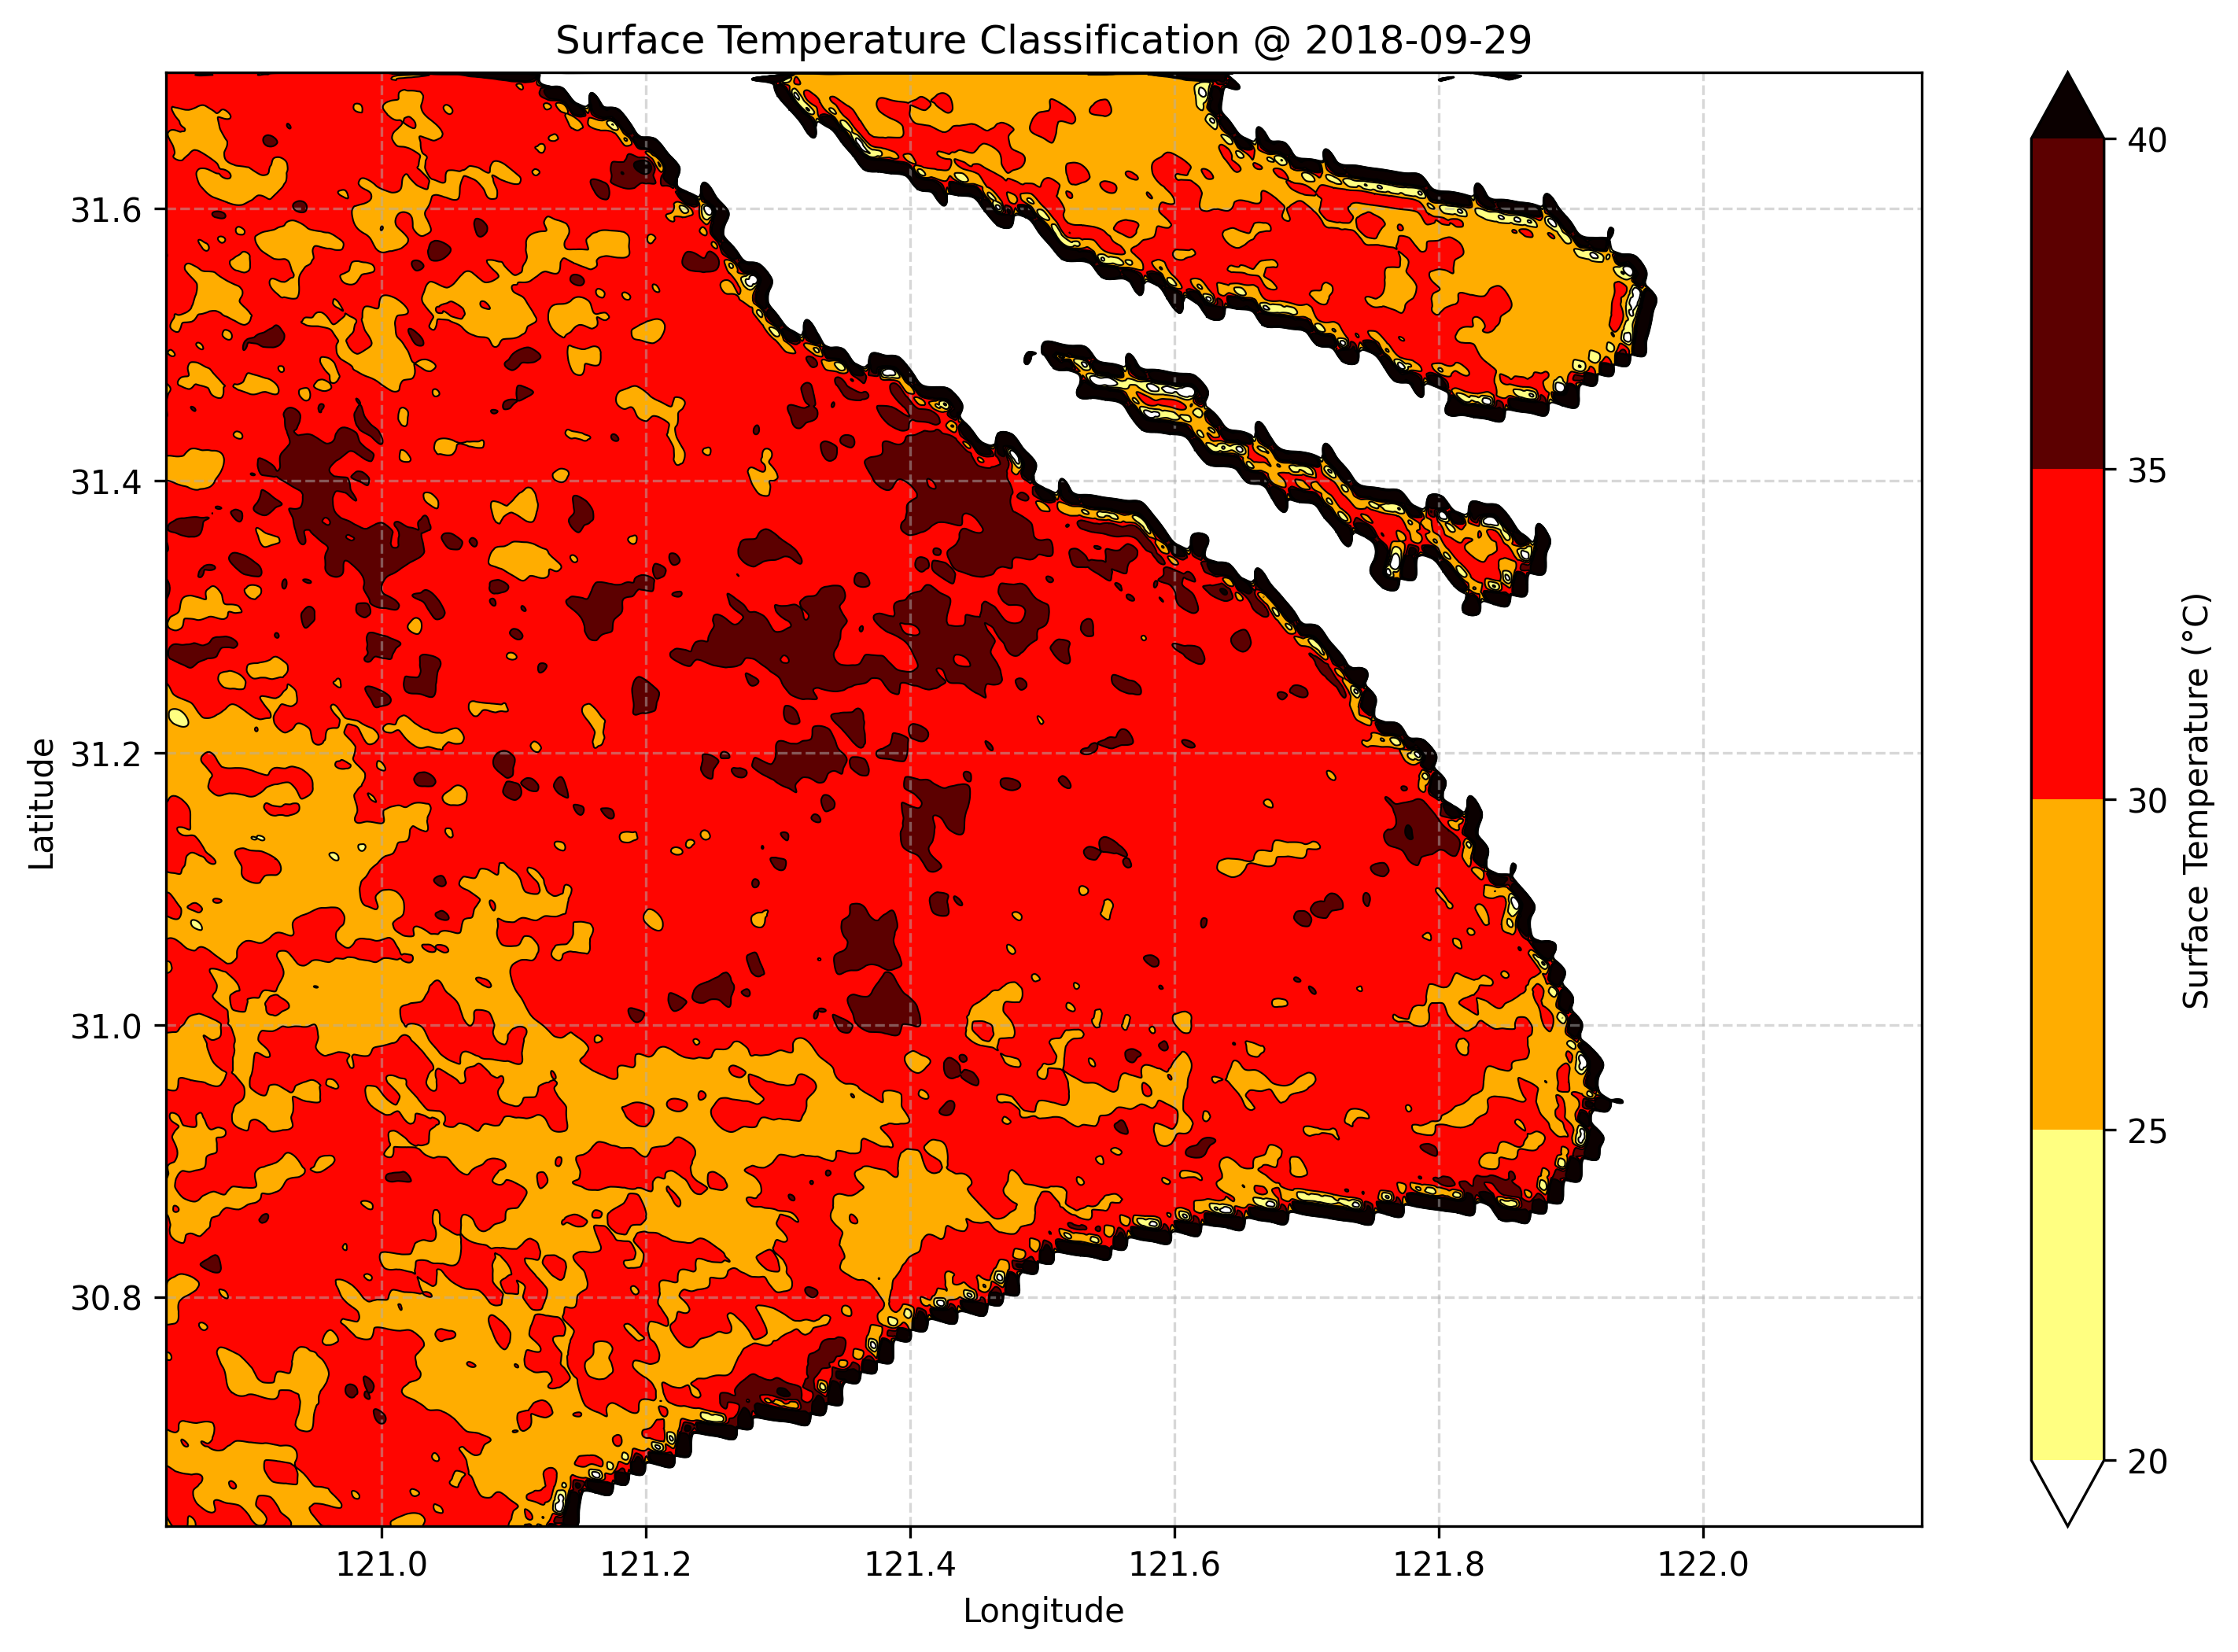

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# 定义温度级别
temperature_levels = np.arange(20, 45, 5)  # 从20℃开始，每5℃划分为一级，最终到达45℃
contour_labels = [f'{level}℃' for level in temperature_levels]

# 绘制分级的等温线图
plt.figure(figsize=(12, 8), dpi=300)

# 使用contourf进行温度分级填充
contours = plt.contourf(grid_x, grid_y, grid_z, levels=temperature_levels, cmap='hot_r', extend='both')

# 添加色标
cbar = plt.colorbar(contours)
cbar.set_label('Surface Temperature (°C)')

# 绘制边界线
plt.contour(grid_x, grid_y, grid_z, levels=temperature_levels, colors='black', linewidths=0.5)

# 添加标题和标签
plt.title(f'Surface Temperature Classification @ {target_dt.strftime("%Y-%m-%d")}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# 网格和显示
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'./tmp_map/tmp_level_{city}_{target_dt.strftime("%Y%m%d")}.png', bbox_inches='tight')
plt.show()

In [68]:
# valid_values = grid_z[(np.isfinite(grid_z)) & (grid_z > 0) & (grid_z < 50)]

# # 计算统计值
# mean_val = np.mean(valid_values)

# # 打印结果
# print(f"均值（有效值）: {mean_val:.2f}")


In [69]:
# import numpy as np

# # 假设 grid_z 是 MxN 的温度矩阵，temperature_levels 是 np.arange(20, 45, 5)
# temperature_bins = [[0, 20], [20, 25], [25, 30], [30, 35], [35, 40], [40, np.inf]]  # 形成区间对

# # 创建掩码矩阵统计每一级别的像素个数
# total_pixels = grid_z.size
# area_ratio = []

# for low, high in temperature_bins:
#     mask = (grid_z >= low) & (grid_z < high)
#     count = np.sum(mask)
#     ratio = count / total_pixels
#     area_ratio.append({
#         'range': f'{low}–{high}℃',
#         'pixel_count': count,
#         'ratio': ratio
#     })

# # 可打印或转为 DataFrame 展示
# import pandas as pd
# df_area_ratio = pd.DataFrame(area_ratio)
# print(df_area_ratio)
# print('热冷面积比：', (area_ratio[4]['ratio'] + area_ratio[5]['ratio']) / (area_ratio[0]['ratio'] + area_ratio[1]['ratio'] + area_ratio[2]['ratio']))

In [70]:
# import numpy as np

# # 定义温度区间
# temperature_bins = [0, 20, 25, 30, 35, 40, np.inf]  # 设置温度区间（包括 >40）
# temperature_labels = [0, 1, 2, 3, 4]  # 对应的标签（0: <20, 1: 20~25, 2: 25~30, 3: 30~35, 4: >40）

# # 将温度值映射到对应的等级
# level_matrix = np.digitize(grid_z, bins=temperature_bins) - 1  # `np.digitize` 返回的是从1开始的等级，减去1调整为从0开始

# # 保存为 .npy 文件
# np.save(f'./tmp_map/tmp_level_matrix_{city}_{target_dt.strftime("%Y%m%d")}.npy', level_matrix)

In [71]:
# grid_z.shape